# Project Overview
## Dataset:
- **Source**: [House Prices in Poland Dataset](https://www.kaggle.com/datasets/dawidcegielski/house-prices-in-poland/data)
- **Availability**: Also included in the project’s Git repository.
- The dataset contains information on house prices, locations, sizes, and other features.

## Goal:
- Predict house prices based on features such as location, size, number of rooms, and more.
- Analyze the impact of city and other attributes on house pricing trends.

---

### Note:
This project is inspired by the tutorial:  
[NeuralNine - House Price Prediction Tutorial](https://www.youtube.com/watch?v=Wqmtf9SA_kk&t=1728s&ab_channel=NeuralNine).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "Houses.csv"
df_houses = pd.read_csv(file_path, encoding='latin-1')

df_houses.head()

,Unnamed: 0,address,city,floor,id,latitude,longitude,price,rooms,sq,year
0,0,Podgórze Zab³ocie Stanis³awa Klimeckiego,Kraków,2.0,23918.0,50.049224,19.970379,749000.0,3.0,74.05,2021.0
1,1,Praga-Po³udnie Grochowska,Warszawa,3.0,17828.0,52.249775,21.106886,240548.0,1.0,24.38,2021.0
2,2,Krowodrza Czarnowiejska,Kraków,2.0,22784.0,50.066964,19.920025,427000.0,2.0,37.00,1970.0
3,3,Grunwald,Poznañ,2.0,4315.0,52.404212,16.882542,1290000.0,5.0,166.00,1935.0
4,4,Ochota Gotowy budynek. Stan deweloperski. Osta...,Warszawa,1.0,11770.0,52.212225,20.972630,996000.0,5.0,105.00,2020.0


## Preprocessing

In [2]:
df_houses["city"].unique()

array(['Kraków', 'Warszawa', 'Poznañ'], dtype=object)

In [3]:
df_houses["city"] = df_houses["city"].str.replace("ó", "o").str.replace("ñ", "n")
df_houses["city"].unique()

array(['Krakow', 'Warszawa', 'Poznan'], dtype=object)

In [4]:
df_houses.drop(columns=["Unnamed: 0", "address", "id"], inplace=True)
df_houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23764 entries, 0 to 23763
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   city       23764 non-null  object 
 1   floor      23764 non-null  float64
 2   latitude   23764 non-null  float64
 3   longitude  23764 non-null  float64
 4   price      23764 non-null  float64
 5   rooms      23764 non-null  float64
 6   sq         23764 non-null  float64
 7   year       23764 non-null  float64
dtypes: float64(7), object(1)
memory usage: 1.5+ MB


In [5]:
# Convert columns data types
columns_to_int = ["year", "floor", "rooms"]
df_houses[columns_to_int] = df_houses[columns_to_int].astype(int)

columns_to_float = ["latitude", "longitude", "price", "sq"]
df_houses[columns_to_float] = df_houses[columns_to_float].astype(float)

In [6]:
df_houses["rooms"].unique()

array([ 3,  1,  2,  5,  4,  6,  8,  7, 10,  9])

### New Feature: `room_category`
- **Description**: Categorizes houses based on the number of rooms:
  - **Small**: 1-2 rooms
  - **Medium**: 3-4 rooms
  - **Big**: 5 or more rooms
- **Purpose**: Simplifies analysis and helps identify patterns related to house size.
- **Methodology**: Derived from the `rooms` column using a mapping function.


In [7]:
def categorize_rooms(num_rooms: int) -> str:
    if num_rooms in [1, 2]:
        return "small"
    elif num_rooms in [3, 4]:
        return "medium"
    else:
        return "big"

df_houses["room_category"] = df_houses["rooms"].map(categorize_rooms)
df_houses.head()


,city,floor,latitude,longitude,price,rooms,sq,year,room_category
0,Krakow,2,50.049224,19.970379,749000.0,3,74.05,2021,medium
1,Warszawa,3,52.249775,21.106886,240548.0,1,24.38,2021,small
2,Krakow,2,50.066964,19.920025,427000.0,2,37.00,1970,small
3,Poznan,2,52.404212,16.882542,1290000.0,5,166.00,1935,big
4,Warszawa,1,52.212225,20.972630,996000.0,5,105.00,2020,big


## Understanding the Data

### Data Correlation Heatmap
- **Method**: 
  - Selected only numerical columns using `select_dtypes`.
  - Computed the correlation matrix and displayed it using a heatmap.
- **Goal**: Identify strongly correlated features that might impact the model.


<Axes: >

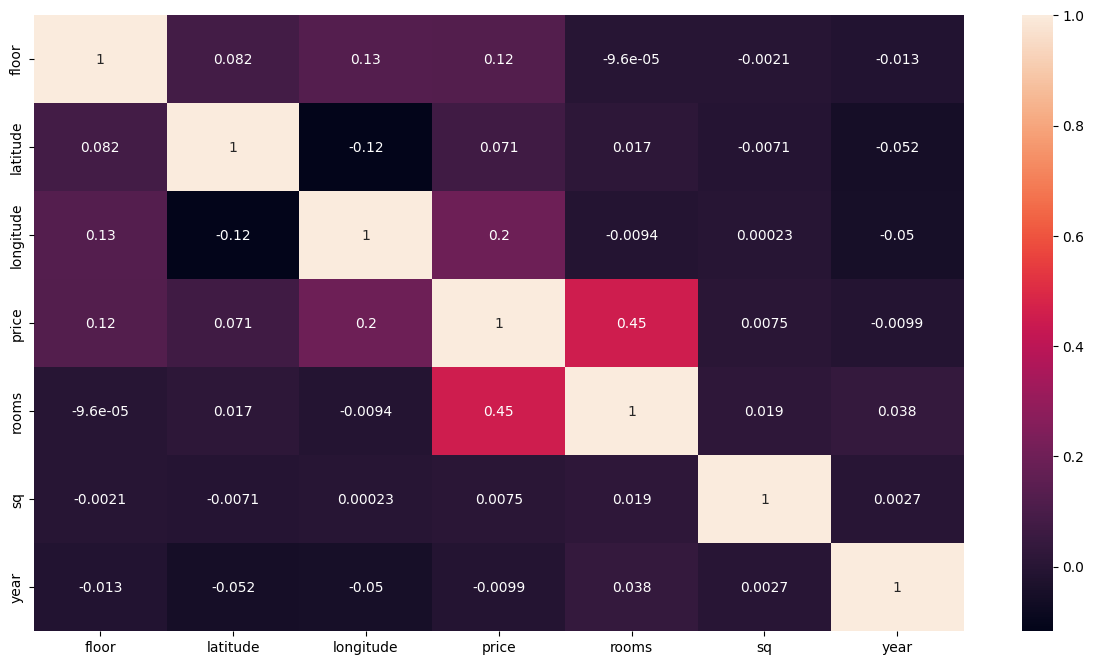

In [8]:
data_correlation = df_houses.select_dtypes(include=["number"]).corr()
plt.figure(figsize=(15,8))
sns.heatmap(data_correlation, annot=True)

### Cell 2: Log Transformation and Data Distribution
- **Method**: 
  - Transformed the selected columns using the natural logarithm (`np.log`).
  - Plotted histograms of transformed features for distribution analysis.
- **Goal**: Normalize data for better model performance.


array([[<Axes: title={'center': 'floor'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>],
       [<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'rooms'}>,
        <Axes: title={'center': 'sq'}>],
       [<Axes: title={'center': 'year'}>, <Axes: >, <Axes: >]],
      dtype=object)

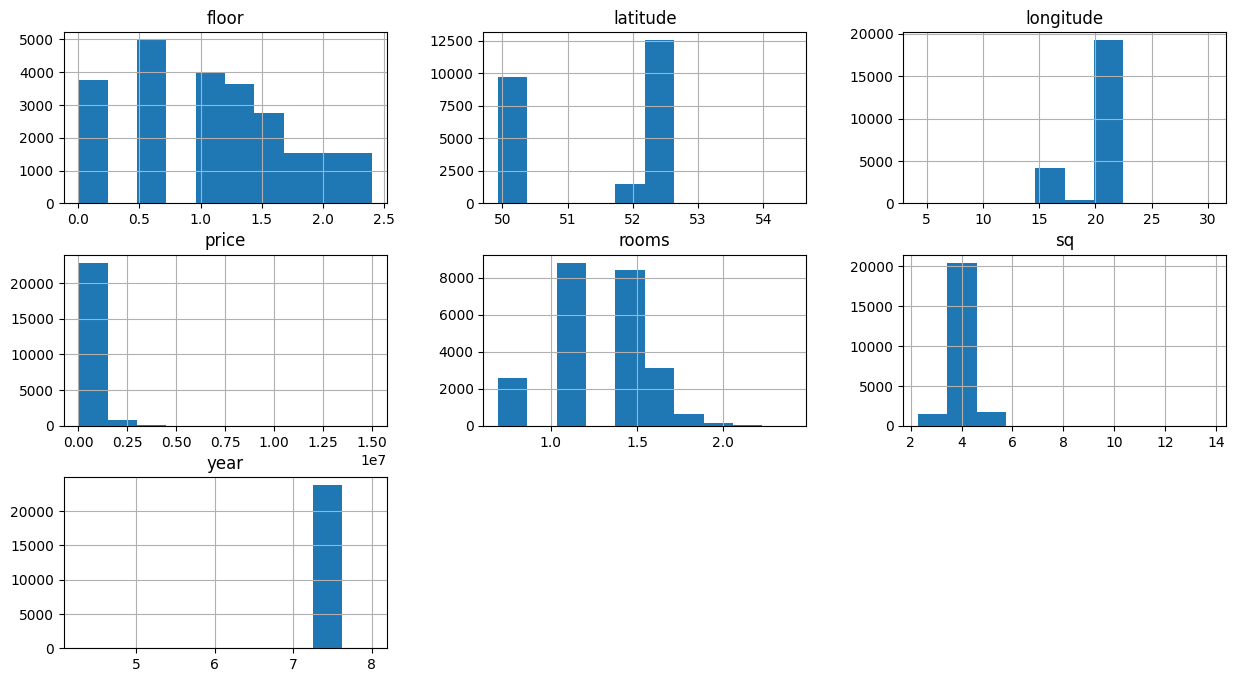

In [9]:
def normalize_data(data: pd.DataFrame, column_name: str) -> pd.DataFrame:
    data[column_name] = np.log(data[column_name] + 1)
    return data
    
columns_to_normalize = ["floor", "rooms", "sq", "year"]
for col in columns_to_normalize:
    df_houses = normalize_data(df_houses, col)

df_houses.hist(figsize=(15,8))

### Cell 3: Encoding for Room Categories
- **Purpose**: Encode the `room_category` feature
- **Method**: 
  - Used `pd.get_dummies` to create one-hot encoded columns.
  - Dropped the original `room_category` column to avoid redundancy.
- **Goal**: Prepare categorical data for the model.


In [10]:
df_houses = df_houses.join(pd.get_dummies(df_houses["room_category"]))
df_houses.drop(columns=["room_category"], axis=1, inplace=True)
df_houses.tail(10)

,city,floor,latitude,longitude,price,rooms,sq,year,big,medium,small
23754,Krakow,1.609438,50.036199,20.000282,570000.0,1.098612,3.856299,7.609367,False,False,True
23755,Poznan,1.098612,52.406882,16.878914,700000.0,1.386294,4.174387,7.603399,False,True,False
23756,Warszawa,0.000000,52.249338,20.897388,590000.0,1.386294,3.988984,7.606387,False,True,False
23757,Warszawa,1.791759,52.263253,21.109533,360000.0,1.386294,3.931826,7.612337,False,True,False
23758,Poznan,1.386294,52.378997,16.944244,294021.0,1.098612,3.589888,7.612337,False,False,True
23759,Poznan,0.000000,52.449649,16.949408,543000.0,1.609438,4.356709,7.611348,False,True,False
23760,Warszawa,1.609438,52.186109,20.948438,910000.0,1.386294,4.276666,7.609862,False,True,False
23761,Poznan,0.000000,52.397345,16.961939,430695.0,1.386294,3.944877,7.612337,False,True,False
23762,Krakow,1.945910,50.024231,19.959569,359000.0,1.098612,3.685373,7.611842,False,False,True
23763,Warszawa,1.098612,52.141039,21.032321,604800.0,1.386294,4.158883,7.590347,False,True,False


### Cell 4: Feature Engineering and Label Encoding
- **Purpose**: 
  - Encode the `city` column into numerical values using `LabelEncoder`.
  - Apply log transformation to the encoded `city` feature.
  - Create a new feature, `sq_ratio`, to represent the ratio of size (`sq`) to the number of rooms (`rooms`).

<Axes: >

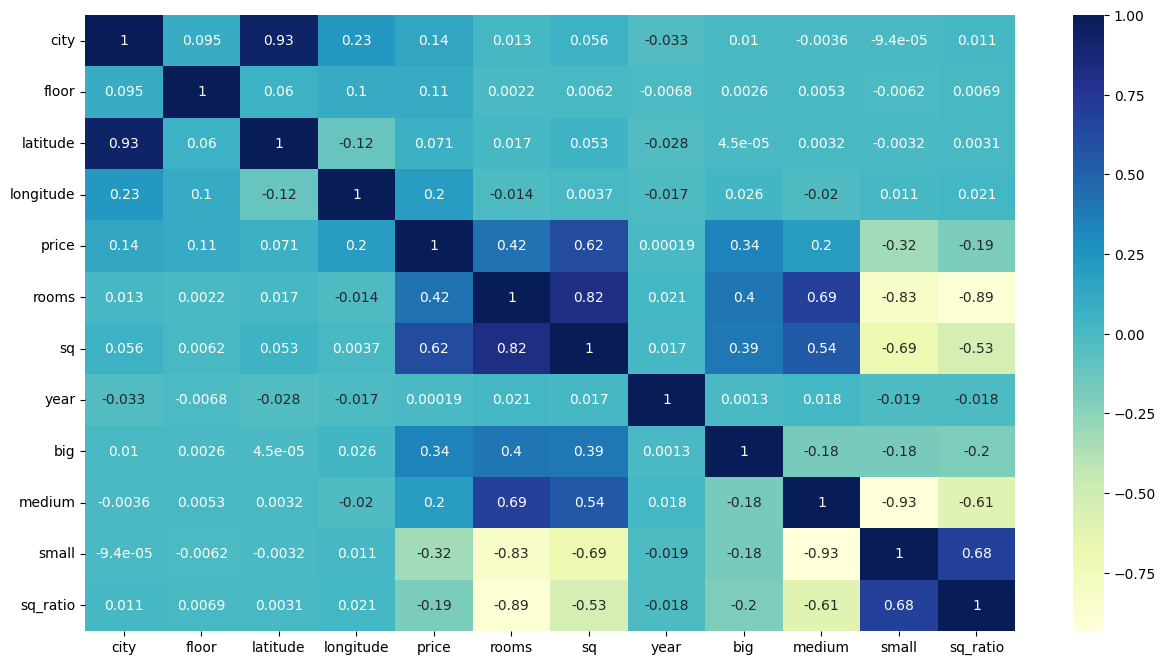

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_houses["city"] = le.fit_transform(df_houses["city"])
df_houses["city"] =  np.log(df_houses["city"] + 1)
df_houses["sq_ratio"] = df_houses["sq"] / df_houses["rooms"]

plt.figure(figsize=(15,8))
sns.heatmap(df_houses.corr(), annot=True, cmap="YlGnBu")

## Building the Model

- Splitting the Data
  - Prepare the dataset for training and testing the model.
  - Split the features (`X`) and target (`y`) into training and testing sets.
  - Used an 80-20 split (`test_size=0.2`) for train-test division.

- Training and Evaluating the Model
  - Trained the model using `LinearRegression` from `sklearn` on the training data (`X_train`, `y_train`).
  - Evaluated the model's performance using the test data (`X_test`, `y_test`)


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = df_houses.drop(["price"], axis=1)
y = df_houses["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=38)

In [13]:
reg = LinearRegression()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.5205906297394098

## Model Accuracy

### Model Evaluation
The model was evaluated using the **LinearRegression** algorithm, trained on 70% of the dataset, with the remaining 30% reserved for testing.<br>
The accuracy of the model on the test set was **52%**

## Random Forest Model - Hyperparameter Tuning
To improve the performance of the model we used Random Forest model, <br>a GridSearchCV was used to search for the best combination of hyperparameters.

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor()

param_grid = {
    'n_estimators': [50],
    'max_depth': [10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

grid_search_rf = GridSearchCV(rf, param_grid, cv=5)
grid_search_rf.fit(X_train, y_train)

best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print(f"Best Params for Random Forest: {best_params_rf}")
print(f"Best Cross-Validation Score for Random Forest: {best_score_rf}")


Best Params for Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-Validation Score for Random Forest: 0.7850105165803353


### Model Performance
The best cross-validation score achieved for the Random Forest model was approximately **0.78** (78%), indicating a significant improvement over the previous model.

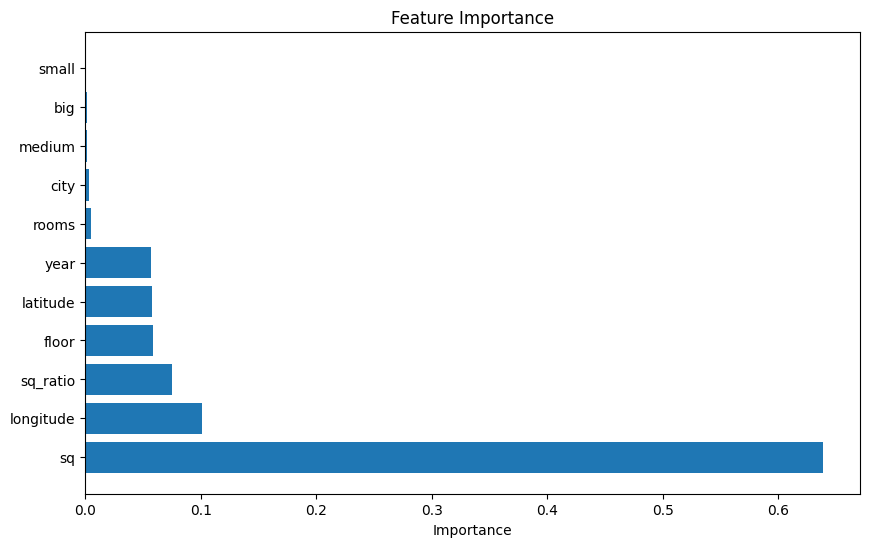

In [15]:
import matplotlib.pyplot as plt

feature_importances = grid_search_rf.best_estimator_.feature_importances_
features = X_train.columns
feature_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'], feature_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

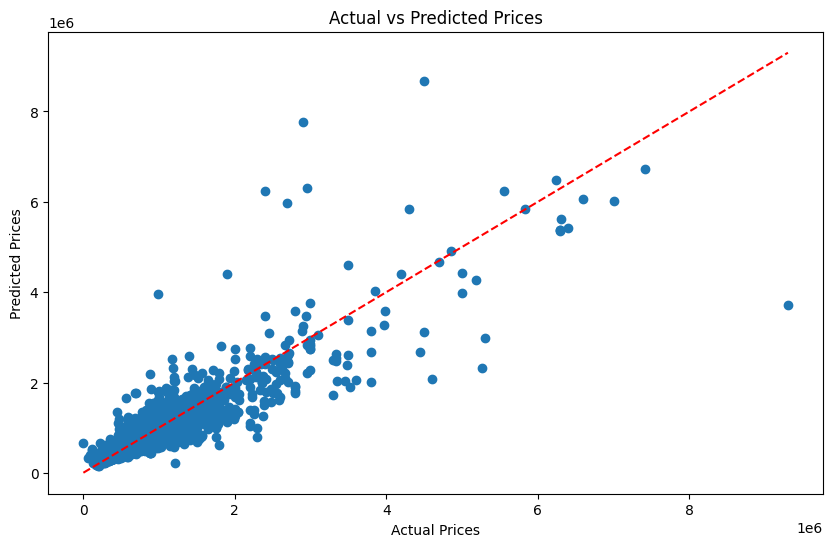

In [16]:
y_pred = grid_search_rf.best_estimator_.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()


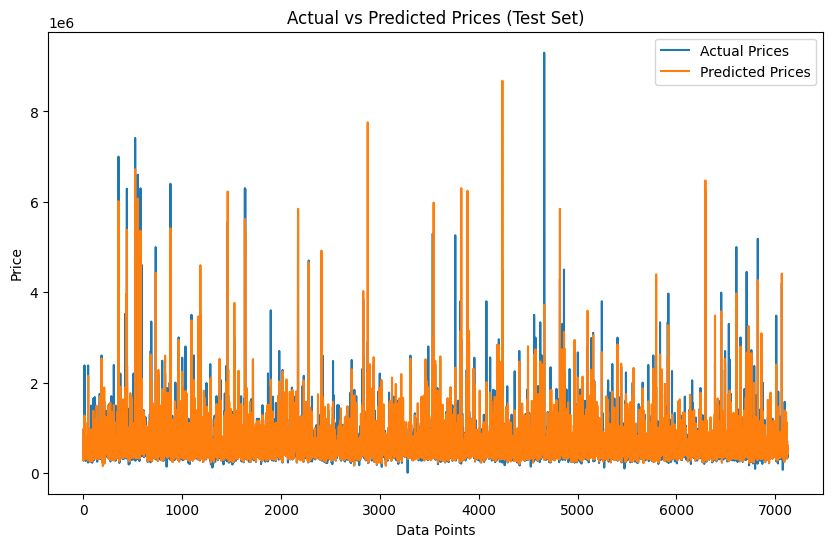

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Prices')
plt.plot(y_pred, label='Predicted Prices')
plt.xlabel('Data Points')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices (Test Set)')
plt.legend()
plt.show()


## Summary
### Feature Importance
- The **sq** feature (square footage) has the highest importance, which is expected as it directly correlates with house size and value.
- Other features, like **floor**, **year**, and **latitude**, also influence the model but to a lesser extent.
 well.

### Key Insights:
- **Good Prediction Accuracy:** The model accurately predicts prices for most of the data, with many points clope (ideal p.dictions).
- **Model Limitations:** While the model performs well for most values, there are a few instances where the predicted values are farther from the actual prices, suggesting there might be outliers or areas where the model's assumptions do not hold.

### Conclusion:
Overall, the Random Forest model perfor (78% of accuracy)ms well, but there is still room for improvement, particularly for higher-priced homes or certain unusual data points. These outliers might be addressed by tuning the model further or using additional features.
